In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pymodulon.core import IcaData
from pymodulon import example_data
from pymodulon.io import save_to_json, load_json_model
from pymodulon.enrichment import *
import plotly.express as px
from pymodulon.plotting import *
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import combinations

In [2]:
ica_data = load_json_model('../data/yarrowia2025.json')


In [3]:
ica_data.sample_table

,File name,condition,project,reference_condition,Strain,Mode of operation,Media,Limitation,C-source,Growth rate,DO,pH,Temperature,Read1,Read2
yl_001,20210204-YL-CN-1,Glucose_Nlimit,Batch_Shaken,Glucose_shaken_reference,W29,Shaken culture,Delft-N limited,Nitrogen,Glucose,0.3,High,6,30,ylipolytic2025_repeat/20210204-YL-CN-1A_1.fq.gz,ylipolytic2025_repeat/20210204-YL-CN-1A_2.fq.gz
yl_002,20210204-YL-CN-2,Glucose_Nlimit,Batch_Shaken,Glucose_shaken_reference,W29,Shaken culture,Delft-N limited,Nitrogen,Glucose,0.3,High,6,30,ylipolytic2025_repeat/20210204-YL-CN-2A_1.fq.gz,ylipolytic2025_repeat/20210204-YL-CN-2A_2.fq.gz
yl_003,20210204-YL-fill-1,Glucose_lowDO,Batch_Shaken,Glucose_shaken_reference,W29,Shaken culture,Delft,Carbon,Glucose,0.3,Low,6,30,ylipolytic2025_repeat/20210204-YL-fill-1A_1.fq.gz,ylipolytic2025_repeat/20210204-YL-fill-1A_2.fq.gz
yl_004,20210204-YL-fill-2,Glucose_lowDO,Batch_Shaken,Glucose_shaken_reference,W29,Shaken culture,Delft,Carbon,Glucose,0.3,Low,6,30,ylipolytic2025_repeat/20210204-YL-fill-2A_1.fq.gz,ylipolytic2025_repeat/20210204-YL-fill-2A_2.fq.gz
yl_005,20210204-YL-ref-1,Glucose_shaken_reference,Batch_Shaken,Glucose_shaken_reference,W29,Shaken culture,Delft,Carbon,Glucose,0.3,High,6,30,ylipolytic2025_repeat/20210204-YL-ref-1A_1.fq.gz,ylipolytic2025_repeat/20210204-YL-ref-1A_2.fq.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yl_096,PD017 A3 S05 #2,µ0.2_DO5,O2_oscillation_0.2,µ0.2_DO10,W29,Continuous,Delft,Carbon,Glucose,0.2,5,6,30,ylipolytic2025_repeat/PD017A3S051A_1.fq.gz,ylipolytic2025_repeat/PD017A3S051A_2.fq.gz
yl_097,PD017 A3 S06 #1,µ0.2_DO2.5,O2_oscillation_0.2,µ0.2_DO10,W29,Continuous,Delft,Carbon,Glucose,0.2,2.5,6,30,ylipolytic2025_repeat/PD017A3S052A_1.fq.gz,ylipolytic2025_repeat/PD017A3S052A_2.fq.gz
yl_098,PD017 A3 S06 #2,µ0.2_DO2.5,O2_oscillation_0.2,µ0.2_DO10,W29,Continuous,Delft,Carbon,Glucose,0.2,2.5,6,30,ylipolytic2025_repeat/PD017A3S061A_1.fq.gz,ylipolytic2025_repeat/PD017A3S061A_2.fq.gz
yl_099,PD017 A3 S07 #1,µ0.2_DO0,O2_oscillation_0.2,µ0.2_DO10,W29,Continuous,Delft,Carbon,Glucose,0.2,0,6,30,ylipolytic2025_repeat/PD017A3S062A_1.fq.gz,ylipolytic2025_repeat/PD017A3S062A_2.fq.gz


In [4]:

def pca_scatter3(df, labels=None, scale=True, label_points=False,name='pca_plot',
                 palette='tab10', figsize=(12, 4), s=45, alpha=0.9):
    """
    PCA on a genes × samples table with a 3‑panel pairwise plot (PC1‑PC3).

    Parameters
    ----------
    df : pandas.DataFrame
        Rows = genes/features, Columns = samples/conditions.
    labels : list‑like or pandas.Series, optional
        A list/category for each column (same length/order as df.columns).
        • If `label_points` is False (default) they are used for *colours*.
        • If `label_points` is True they are drawn as *text* at each point.
    scale : bool, default True
        Standard‑scale each gene before PCA (zero mean, unit variance).
    label_points : bool, default False
        If True, annotate each point with the corresponding entry in `labels`.
        If False, unique entries in labels are mapped to colours with a legend.
    palette : str or sequence
        Matplotlib colour palette name or explicit colour list.
    figsize : tuple, default (12, 4)
        Overall figure size (three equal‑width panels).
    s : int or float, default 45
        Marker size for scatter points.
    alpha : float, default 0.9
        Marker transparency.

    Returns
    -------
    pca : sklearn.decomposition.PCA
        The fitted PCA object (for further inspection if needed).
    """
    # ---------- 1. prepare the data (samples as rows) ----------
    X = df.T.values                                       # (n_samples, n_genes)
    if scale:
        X = StandardScaler().fit_transform(X)

    # ---------- 2. run PCA ----------
    pca = PCA(n_components=3, random_state=0)
    PCs = pca.fit_transform(X)                            # shape = (n_samples, 3)
    expl = pca.explained_variance_ratio_ * 100            # %

    # ---------- 3. reporting ----------
    print("Variance explained: "
          f"PC1 = {expl[0]:.1f} %,  PC2 = {expl[1]:.1f} %,  PC3 = {expl[2]:.1f} %")

    # ---------- 4. figure set‑up ----------
    fig, axes = plt.subplots(1, 3, figsize=figsize, sharex=False, sharey=False)

    # colours / text for each point
    if labels is None:
        labels = np.repeat('', len(df.columns))           # blank labels
    labels = pd.Series(labels, index=df.columns)

    if label_points:
        colour_map = np.full(len(labels), 'tab:blue')     # one colour, text only
    else:
        uniq = labels.unique()
        palette = plt.get_cmap(palette).colors if isinstance(palette, str) else palette
        colour_map = labels.apply(lambda z: palette[list(uniq).index(z) % len(palette)])

    # ---------- 5. scatter on PC pairs ----------
    axes_pairs = [(0, 1), (0, 2), (1, 2)]
    for ax, (i, j) in zip(axes, axes_pairs):
        ax.scatter(PCs[:, i], PCs[:, j], c=colour_map, s=s, alpha=alpha, edgecolor='k')
        ax.set_xlabel(f"PC{i+1} ({expl[i]:.1f} %)")
        ax.set_ylabel(f"PC{j+1} ({expl[j]:.1f} %)")
        ax.xaxis.set_major_locator(MaxNLocator(5))
        ax.yaxis.set_major_locator(MaxNLocator(5))
        ax.axhline(0, color='grey', lw=0.6)
        ax.axvline(0, color='grey', lw=0.6)

        if label_points:
            for (x, y), txt in zip(PCs[:, [i, j]], labels):
                ax.text(x, y, str(txt), fontsize=8,
                        ha='center', va='center',
                        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))

    # common legend (colour‑based) if not text labelling
    if not label_points and labels.nunique() > 0:
        handles = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=palette[k % len(palette)],
                              markeredgecolor='k', markersize=np.sqrt(s))
                   for k, _ in enumerate(labels.unique())]
        axes[-1].legend(handles, labels.unique(), frameon=False,
                        bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(name+'.png',dpi=300,transparent=True)
    return pca


Variance explained: PC1 = 24.8 %,  PC2 = 13.0 %,  PC3 = 9.0 %


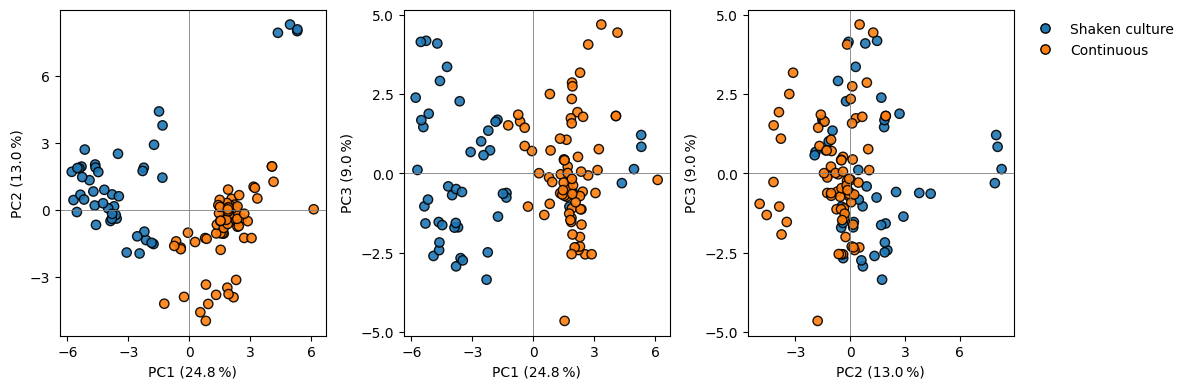

In [5]:
pca_model = pca_scatter3(ica_data.A, labels=ica_data.sample_table['Mode of operation'].tolist(), scale=True, label_points=False,name='tpm_pca')
#plt.savefig('tpm_pca.png',dpi=300,transparent=True)

Text(0.5, 1.0, 'PC3 loadings')

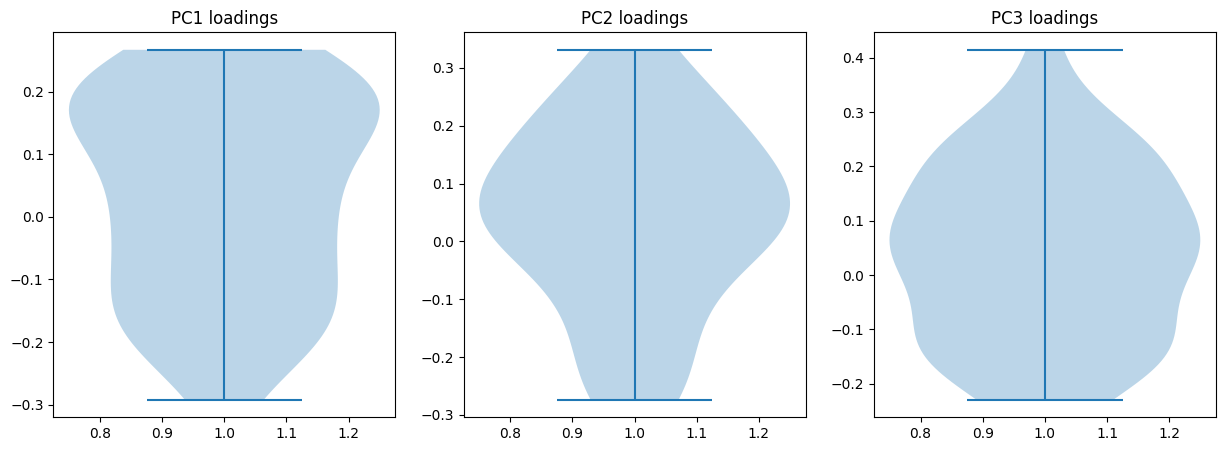

In [6]:
loadings = pd.DataFrame(pca_model.components_).T

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.violinplot(loadings[0])
plt.title('PC1 loadings')

plt.subplot(1,3,2)
plt.violinplot(loadings[1])
plt.title('PC2 loadings')

plt.subplot(1,3,3)
plt.violinplot(loadings[2])
plt.title('PC3 loadings')

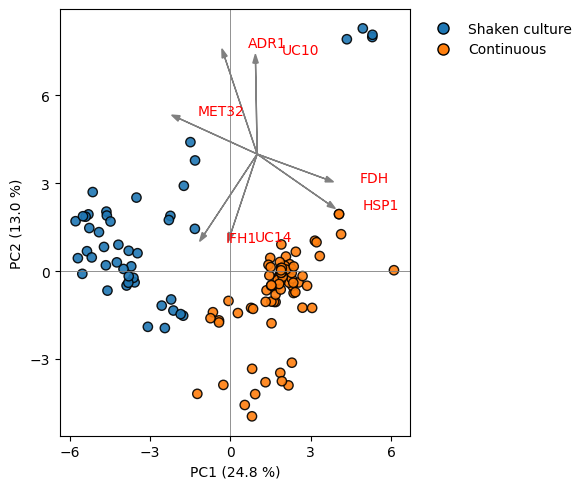

In [11]:
df = ica_data.A
X  = StandardScaler().fit_transform(df.T.values)

labels = pd.Series(ica_data.sample_table['Mode of operation'])   # keep as Series

PCs  = pca_model.fit_transform(X)
expl = pca_model.explained_variance_ratio_ * 100

# ---------- 2. build a colour map ----------------------------------------
uniq     = labels.unique()
palette  = plt.get_cmap('tab10').colors          # or any other MPL palette
colours  = labels.map(lambda z: palette[list(uniq).index(z) % len(palette)])

# ---------- 3. plot -------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(PCs[:, 0], PCs[:, 1], c=colours, s=45, alpha=0.9, edgecolor='k')

ax.set_xlabel(f"PC1 ({expl[0]:.1f} %)")
ax.set_ylabel(f"PC2 ({expl[1]:.1f} %)")
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.axhline(0, color='grey', lw=0.6); ax.axvline(0, color='grey', lw=0.6)

# ---------- 4. legend -----------------------------------------------------
handles = [plt.Line2D([0], [0], marker='o', linestyle='',
                      markerfacecolor=palette[i % len(palette)],
                      markeredgecolor='k', markersize=8)
           for i in range(len(uniq))]
ax.legend(handles, uniq, frameon=False,
          bbox_to_anchor=(1.02, 1), loc='upper left')



##Add in arrows for biplot

loadings = pd.DataFrame(pca_model.components_).T
loadings.rename(columns={0: 'PC1', 1: 'PC2', 2:'PC3'}, inplace=True)

pc1_loadings = [2,14,16]
pc2_loadings = [4,18,24,27]

arrows_to_make = pc1_loadings+pc2_loadings#['gcvB','ppGpp','Crp-1','Translation','Thiamine-1','RpoS','SoxS','Microaerobic','Pyrimidine','Arginine','LPS']#['FHL','ppGpp','gcvB','ArcA','Microaerobic','SoxS','pts ALE']
#arrow_texts = [ica_data.imodulon_table['iModulon Name'][w] for w in arrows_to_make]
# arrow length variable extends arrows to help in interpreting the plot
# text_scale determines how far text labels are from arrow tips (1 = on top of them)
arrow_length = 10
text_scale = 1.1

# the place the arrows start is up to you, so you can move it out of the way
start1 = 1
start2 = 4

# loop through each gene and add its arrow
for g in arrows_to_make:
    # directions in PC1 and 2
    g_weight_pc1 = loadings.loc[g, 'PC1']
    g_weight_pc2 = loadings.loc[g, 'PC2']
    
    # lengthen arrow by a constant factor
    g_weight_pc1 = g_weight_pc1 * arrow_length
    g_weight_pc2 = g_weight_pc2 * arrow_length
    
    # add the arrow
    ax.arrow(start1, start2, g_weight_pc1, g_weight_pc2, head_width = 0.2,color='grey')

    ax.text(start1 + (text_scale * g_weight_pc1)+1,
            start2 + (text_scale * g_weight_pc2), 
            ica_data.imodulon_table['iModulon Name'][g],size=10,color='red')


plt.tight_layout()
plt.show()

In [ ]:
loadings[]

,PC1,PC2,PC3
0,0.033461,0.229073,-0.025594
1,-0.157205,0.045422,-0.014780
2,0.256656,-0.085561,0.053225
3,0.160680,0.172233,0.106004
4,-0.121707,0.331156,-0.179403
5,-0.045250,0.257754,-0.229834
6,-0.177085,-0.232446,-0.115802
7,0.101063,0.221741,0.239107
8,-0.075023,0.137150,0.227290
9,-0.167080,-0.123632,0.215660
